In [11]:
# Imports
import pandas as pd
import numpy as np
import os
from utils import (
    get_rules_list,
    create_train_test_split,
    train_model,
    create_adv_train_test_split,
    test_evasion,
    log,
)
from modsec import init_modsec

from sklearn.ensemble import RandomForestClassifier
from wafamole.evasion import EvasionEngine  # type: ignore

log("Starting...")
rule_ids = get_rules_list()
modsec = init_modsec()

Starting...


In [12]:
# Set up variables

use_data_from_disk = False
use_data_from_disk_adv = False

attack_data_path = "data/raw/attacks_full.sql" # raw attack data
sane_data_path = "data/raw/sanes_full.sql" # raw sane data
processed_data_path = "data/preprocessed/5"  # path to store the preprocessed train and test data

paranoia_level = 5

train_attacks_size = 1000  # paper uses 10000
train_sanes_size = 1000 # paper uses 10000
test_attacks_size = 200  # paper uses 2000
test_sanes_size = 200  # paper uses 2000

train_adv_size = 500  # paper uses 5000 (1/4 of total train set size)
test_adv_size = 200  # paper uses 2000 (1/2 of total test set size)

engine_settings = {
    "max_rounds": 200,
    "round_size": 10,
    "timeout": 5,
}

model = RandomForestClassifier(n_estimators=160, random_state=666)
model_adv = RandomForestClassifier(n_estimators=160, random_state=666)

In [13]:
# Create train and test sets

if (not use_data_from_disk) :
    if not os.path.exists(processed_data_path):
        os.makedirs(processed_data_path)
    train, test = create_train_test_split(
        attack_file=attack_data_path,
        sane_file=sane_data_path,
        train_attacks_size=train_attacks_size,
        train_sanes_size=train_sanes_size,
        test_attacks_size=test_attacks_size,
        test_sanes_size=test_sanes_size,
        modsec=modsec,
        rule_ids=rule_ids,
        paranoia_level=paranoia_level,
    )
    train.to_csv(f"{processed_data_path}/train_{train_attacks_size + train_sanes_size}.csv", index=False)
    test.to_csv(f"{processed_data_path}/test_{test_attacks_size + test_sanes_size}.csv", index=False)
    log("Train and test sets created", True)
else :
    # load the train and test sets from disk
    train = pd.read_csv(f"{processed_data_path}/train_{train_attacks_size + train_sanes_size}.csv")
    test = pd.read_csv(f"{processed_data_path}/test_{test_attacks_size + test_sanes_size}.csv")
    train['vector'] = train['vector'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))
    test['vector'] = test['vector'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))

Reading and parsing data...


KeyboardInterrupt: 

Model trained successfully!
Evaluating model...
Default threshold: 0.5
FRP is currently at 0.0455
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       500
           1       0.95      0.92      0.94       500

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



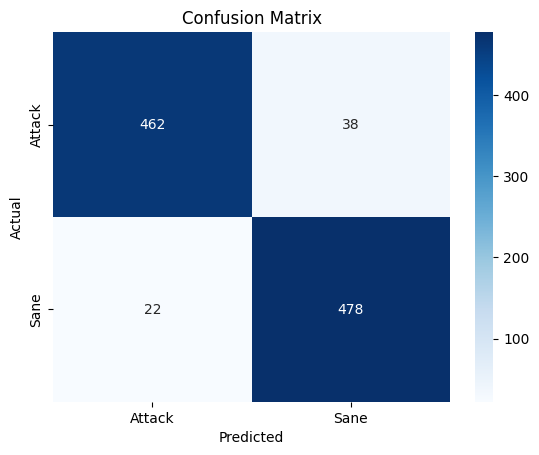

Adjusting threshold to match desired FPR of 0.01


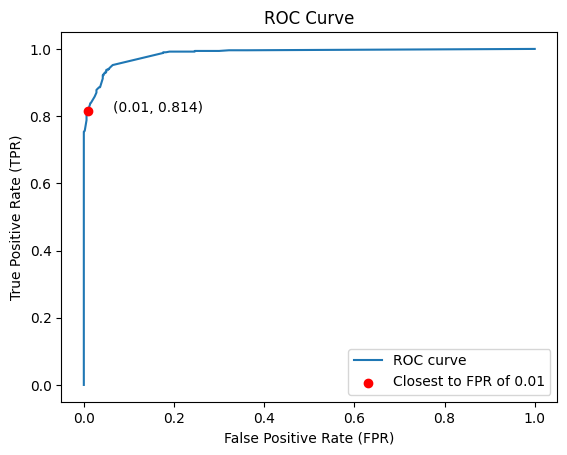

Adjusted threshold: 0.8342 with FPR of 0.01 (closest to desired FPR 0.01)
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       500
           1       0.99      0.81      0.89       500

    accuracy                           0.90      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.90      0.90      1000



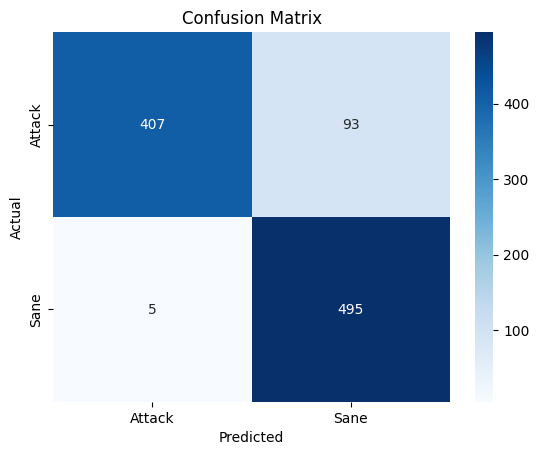

In [ ]:
# Train the model

model_trained, threshold = train_model(
    train=train,
    test=test,
    model=model,
    desired_fpr=0.01
)

In [ ]:
# adversarial training
if not use_data_from_disk_adv:
    train_adv, test_adv = create_adv_train_test_split(
        train=train,
        test=test,
        train_adv_size=train_adv_size,
        test_adv_size=test_adv_size,
        model_trained=model_trained,
        engine_settings={
            **engine_settings,
            "threshold": threshold,
        },
        modsec=modsec,
        rule_ids=rule_ids,
        paranoia_level=paranoia_level,
        batch_size=100,
    )
    train_adv.to_csv(
        f"{processed_data_path}/train_adv_{train_adv_size}.csv", index=False
    )
    test_adv.to_csv(f"{processed_data_path}/test_adv_{test_adv_size}.csv", index=False)
    log("Adversarial train and test sets created", True)
else:
    # load the train_adv and test_adv sets from disk
    train_adv = pd.read_csv(f"{processed_data_path}/train_adv_{train_adv_size}.csv")
    test_adv = pd.read_csv(f"{processed_data_path}/test_adv_{test_adv_size}.csv")
    train_adv["vector"] = train_adv["vector"].apply(
        lambda x: np.fromstring(x[1:-1], sep=" ")
    )
    test_adv["vector"] = test_adv["vector"].apply(
        lambda x: np.fromstring(x[1:-1], sep=" ")
    )

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
# train new model with train + train_adv

model_adv_trained, threshold_adv = train_model(
    train=pd.concat([train, train_adv]).sample(frac=1).reset_index(drop=True),
    test=pd.concat([test, test_adv]).sample(frac=1).reset_index(drop=True),
    model=model_adv,
    desired_fpr=0.01,
)

In [ ]:
# Test the model (without adversarial training)
test_evasion(
    payload='SELECT SLEEP(5)#";',
    threshold=threshold,
    model=model_trained,
    engine_eval_settings={
        "max_rounds": 200,
        "round_size": 10,
        "timeout": 60,
        "threshold": 0.0,
    },
    modsec=modsec,
    rule_ids=rule_ids,
    paranoia_level=paranoia_level,
)

In [ ]:
# Test the model (with adversarial training)
test_evasion(
    payload='SELECT SLEEP(5)#";',
    threshold=threshold,
    model=model_adv_trained,
    engine_eval_settings={
        "max_rounds": 200,
        "round_size": 10,
        "timeout": 60,
        "threshold": 0.0,
    },
    modsec=modsec,
    rule_ids=rule_ids,
    paranoia_level=paranoia_level,
)